# Audio MNIST Classification using MFCCs and Simple Neural Network
## Taeang Moon

In [1]:
# For Audio Preprocessing
import librosa
import librosa.display as dsp
from IPython.display import Audio

# For Data Preprocessing
import pandas as pd
import numpy as np
import os

# For data viz
import matplotlib.pyplot as plt
from tqdm import tqdm

# The Goal and the Data

In this project, I aim to classify voice samples of spoken digits (0-9) using a simple neural network. The Audio MNIST data I use contains 30000 audio samples of spoken digits from 60 different speakers. An example and visualization of one of the samples is shown below. 

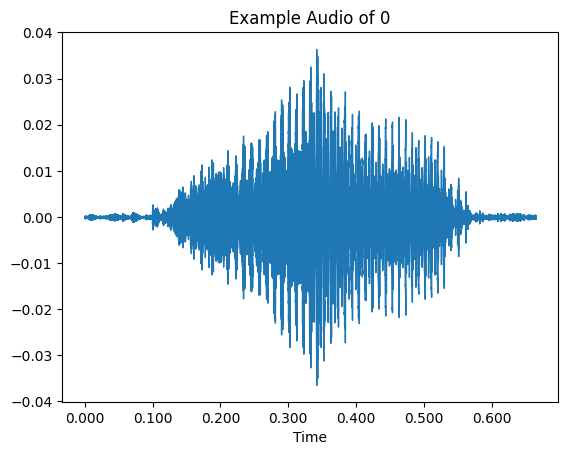

In [2]:
def show_audio(digit=0):
    # Audio Sample Directory
    sample = np.random.randint(1,60)
    # Index of Audio
    index = np.random.randint(1,5)
    
    # Modified file location
    if sample < 10:
        file = f"../input/audio-mnist/data/0{sample}/{digit}_0{sample}_{index}.wav"
    else:
        file = f"../input/audio-mnist/data/{sample}/{digit}_{sample}_{index}.wav"

    
    # Get Audio from the location
    data,sample_rate = librosa.load(file)
    
    # Plot the audio wave
    dsp.waveshow(data,sr=sample_rate)
    plt.title(f"Example Audio of {digit}")
    plt.show()
    
    # Show the widget, audio
    return Audio(data=data,rate=sample_rate)
# Show the audio and plot of digit 0
show_audio(0)

Although this is a very easy to understand visualization of the audio, we must change the representation of the data to be able to use it in a deep learning classification task. This is where MFCCs come into play. 

# MEL FREQUENCY CEPSTRAL COEFFICIENT (MFCC)

A basic idea of sound waves (and waves in general) is that they can be represented by a series of sines and cosines (Fourier Series/Transforms). MFCCs are based off of this idea and represents these spectrums/sound waves more compactly. In particular, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound. The MFCCs then are the coefficients that make up this representation. We can think of this as the MFC representing individual cuts of the audio with a simplified Fourier transform (sum of sines and cosines) and the MFCCs being the amplitudes for those simplified expressions. Note I am oversimplifying this explanation as the math and theory behind this concept can get complex. However, this broad-view explanation should suffice for the purposes of understanding this notebook. 

In short, we can think of the MFCCs of a sound to be a set of coefficients that describe the general shape of the audio waves. If a coefficient has a positive value, the majority of the portion of the audio we are looking at is concentrated in the low-frequency regions and vice versa. These coefficients can also be thought of as describing the "timbre" of a sound. 

The code below loads the data and extracts the MFCCs of the audio files. To keep the dataset as small as possible, I take the mean and standard deviation of the coefficients across the time frames for each file. You can see the resulting pandas dataframe in the output below (with their associated labels). 

In [4]:
# Audio parameters
SR = 22050 # sample rate
N_MFCC = 13 # number of coefficients
HOP_LENGTH = 512 # number of samples between successive frames
def extract_features():
    data = []
    # Loop over the files
    for person in tqdm(range(1, 61)): # from 1 to 60 (60 different people)
        for record in range(50): # from 0 to 49 (50 record numbers per person)
            for digit in range(10): # from 0 to 9 (10 spoken digits)
                if person < 10:
                    file = f'../input/audio-mnist/data/0{person}/{digit}_0{person}_{record}.wav'
                else:
                    file = f'../input/audio-mnist/data/{person}/{digit}_{person}_{record}.wav'
                # Get MFCC
                audio = librosa.load(file)[0]
                # librosa.load returns two things:
                # First a 2D array:
                #    The first axis: the recorded samples of amplitudes (change of air pressure) in the audio.
                #    The second axis: num of channels in audio.
                # Second a sample rate sr: how many samples are recorded per second
                # ex. sample rate = 22050 means that recorder was recording 22050 times per second.
                # y.shape = (1355168,) means that there were 1355168 samples recorded on just one channel over the whole audio.
                # Calculate the duration of this audio file by dividing the total_number_of_samples over the sample_rate
                mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=N_MFCC, hop_length=HOP_LENGTH)
                # will take a audio file as input and output extracted features using MEL FREQUENCY CEPSTRAL COEFFICIENT
                # returns # of mfc coeffs (rows), # of time frames (cols)
                # ex. first row = first mfcc over 13 time frames
                # Take mean and variance of the features across all time frames
                mean = mfcc.mean(axis=1).tolist()
                var = mfcc.var(axis=1).tolist()
                features = mean + var + [digit]
                data.append(features)
    
    # Create dataframe
    cols = ['mean_' + str(x+1) for x in range(N_MFCC)] + ['var_' + str(x+1) for x in range(N_MFCC)] + ['Digit']
    df = pd.DataFrame(data, columns=cols)
                
    return df
# Get and save the dataframe
df = extract_features()
df.to_csv('mfccs.csv', index=False)
df


100%|██████████| 60/60 [15:03<00:00, 15.05s/it]


,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,mean_9,mean_10,...,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,Digit
0,-617.908264,101.589775,9.847573,26.403585,25.784239,1.755383,7.380788,-12.520161,8.840898,-0.251342,...,524.241394,117.931816,122.885178,637.004639,92.920158,62.865093,96.420944,109.956810,41.682262,0
1,-664.994507,149.610596,26.261110,23.693588,19.233938,-3.658054,6.188643,-10.573393,9.452542,-5.766150,...,650.744263,875.923096,125.463867,192.702332,48.036602,70.113045,102.460480,73.125137,35.113697,1
2,-627.440125,117.020615,24.828531,25.543552,19.895426,1.942104,-3.384884,0.424578,5.882212,-8.079786,...,141.031387,78.117470,306.251129,385.132538,90.266289,188.860916,143.997879,54.707264,90.763763,2
3,-638.245483,71.061691,18.628624,47.587078,38.369740,3.692852,4.340428,-14.081757,6.751021,3.282107,...,691.583740,678.009155,102.747574,318.735687,192.386459,92.577637,190.523102,41.448807,31.486139,3
4,-617.039429,111.224503,19.910681,10.943748,3.801412,-0.992973,5.456501,2.375249,0.115830,4.444156,...,407.881958,604.594849,120.317947,82.729446,93.410423,110.351700,26.764675,57.042217,38.519764,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-593.262329,83.958626,0.158356,19.119814,20.681587,-1.247262,-14.194125,-5.699879,3.503340,-3.492440,...,248.938354,292.115814,147.103134,44.199112,45.924152,113.602730,105.765762,62.956795,103.097992,5
29996,-627.726746,6.596435,45.909420,21.094339,25.157547,8.356222,-15.353575,10.993065,0.949311,5.708887,...,121.487068,501.463013,260.830688,54.665565,60.621597,172.038940,30.416479,20.251801,34.639465,6
29997,-650.393005,54.268787,49.887550,33.189381,28.416016,0.032355,-13.128325,8.463138,2.164517,-4.893999,...,152.967743,424.310211,202.662476,104.758743,59.871250,97.842300,104.263130,35.896198,51.708698,7
29998,-645.051636,58.739948,33.491364,45.197094,23.291288,-10.977055,-16.720655,8.397923,-6.022536,-10.304352,...,97.494362,566.041931,211.561142,76.688248,207.825012,150.414169,28.763342,31.970465,227.941193,8


# Preprocessing

In the table above, each row corresponds to a single recording in the Audio MNIST dataset. Before I use this table in my model I preprocess the data with a couple of simple steps. First, I split the data into a training and test set with 80% going to training and 20% going to test. We can also see above that the data is ordered very neatly by the spoken digit. Thus, I also shuffle this dataset. Finally, I scale the data using the sklearn StandardScaler. Note, I scale each set of data independently from each other so that the training set does not incorporate information from the test set. Below shows the resulting training set. 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split X and y into own data
X = df.drop('Digit', axis=1)
y = np.array(df['Digit'])
    
# Train-test split (80 train, 20 test) and shuffle data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=0)
    
# Scale X
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns).reset_index(drop=True)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns).reset_index(drop=True)

# output xtrain
X_train

,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,mean_9,mean_10,...,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13
0,2.086705,0.435896,-2.156347,-1.601826,-1.459778,0.735728,-1.581425,-1.790468,-0.034332,0.688563,...,-0.470541,1.159765,-1.256641,1.153456,-0.448402,-1.275638,0.395966,-0.398579,-0.932792,-0.862047
1,1.330480,0.220620,-1.714264,-1.550781,-1.461702,0.034676,0.566531,-0.428203,-0.150100,-0.572236,...,0.000020,1.536547,-0.749168,-0.108157,0.120059,-0.997182,1.247785,-0.572297,-0.501727,-0.847160
2,-0.672531,-0.059054,0.919376,1.955714,1.462859,-1.317976,-1.933751,-0.461803,2.546472,-2.134002,...,1.872363,-0.566251,0.840515,0.790723,-0.609203,-0.944193,6.805510,-0.008023,-0.691950,-1.016318
3,-0.911209,0.490279,2.114284,0.510894,0.913884,1.757787,0.384733,1.276141,0.488055,-1.849665,...,0.776809,0.129474,-0.623852,-0.022504,-0.767358,0.171072,0.833046,0.585202,0.128048,0.250284
4,0.133088,-0.691374,0.140656,0.159159,0.517279,1.317748,0.073473,-0.329974,-0.418009,-0.715485,...,-0.800561,0.993523,0.196327,-0.447207,-0.300689,2.388922,-0.265153,-1.060953,-0.630744,0.093655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.779996,-0.083485,-0.208268,1.684604,1.898961,-0.769080,-0.090562,-0.453101,0.910688,-0.040111,...,1.842527,-0.625839,-0.251078,0.174834,-0.411978,-1.018699,-1.105339,1.570183,-1.117940,0.356034
23996,1.141661,-0.818014,-1.008819,1.622635,0.578046,-1.407836,-2.108026,-0.156087,1.504664,-0.312461,...,0.124670,1.164926,1.349054,3.259680,-0.642359,-0.279483,0.068094,-0.166857,-0.659001,-1.109548
23997,0.140241,0.462000,-1.430681,-1.139356,-0.298894,-0.914178,-0.469812,-1.154650,0.014861,-0.034334,...,-0.093134,-0.382098,-0.141361,0.271655,-0.384422,-1.085100,-0.631099,0.936270,-0.953022,-0.072773
23998,-0.083360,0.812136,-1.074822,0.075598,0.605385,0.157312,-0.580431,0.688135,-0.358430,-1.286995,...,-0.047842,-0.785928,-1.074442,0.134500,-1.305280,0.045876,-0.594117,-0.731076,-0.633140,4.775123


# Model

Now, we can create the model. I chose to use a very simple model consisting of a short stack of dense neural networks. In particular, the model takes in vectors of the MFCC means and variances I processed above and runs it through 3 densely connected layers each with 100 neurons and ReLU activation functions. The final layer is another dense connected layer with 10 output neurons (1 for each class) and it uses a Softmax activation function at the end (to classify the results into each class). Since this is a multilabel classification problem where each class has an index, I use a Sparse Categorical Crossentropy loss to train the model. To keep runtime short I only go through 10 epochs below using a batch size of 32. 

In [6]:
# Tensorflow Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Model architecture
model = Sequential([
    Dense(100, input_shape=(N_MFCC * 2,), activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
)

num_epochs = 10
batch_size = 32

# Fit the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)

2024-04-02 15:33:42.722950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 15:33:42.723082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 15:33:42.891616: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8186 - loss: 0.6147 - val_accuracy: 0.9727 - val_loss: 0.0831
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9708 - loss: 0.0851 - val_accuracy: 0.9795 - val_loss: 0.0639
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9783 - loss: 0.0634 - val_accuracy: 0.9835 - val_loss: 0.0485
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9847 - loss: 0.0438 - val_accuracy: 0.9823 - val_loss: 0.0494
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9878 - loss: 0.0350 - val_accuracy: 0.9818 - val_loss: 0.0550
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9920 - loss: 0.0250 - val_accuracy: 0.9867 - val_loss: 0.0477
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9932 - loss: 0.0221 - val_accuracy: 0.9787 - val_loss: 0.0710
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9932 - loss: 0.0192 - val_accuracy: 0.9827 - val_

The trajectory of the model's loss and accuracy for both the test and training set are shown in the plots below. Given the closeness of the training set (blue) values to the test set (orange) values, we can conclude that the model is not overfitting to the training data. 

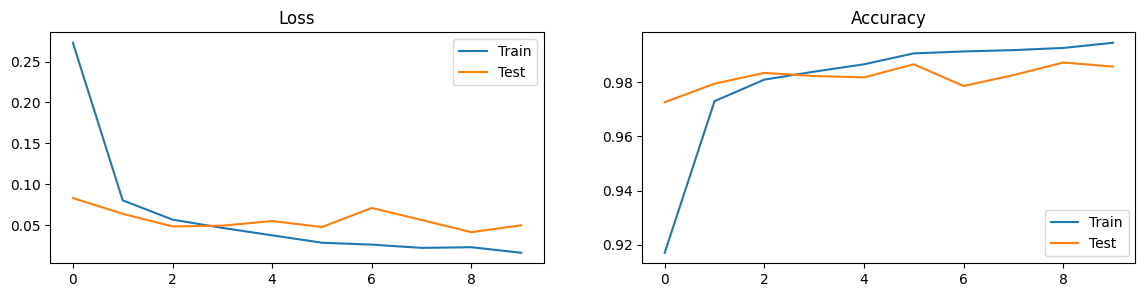

In [7]:
plt.figure(figsize=(14, 3))

plt.subplot(121)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Test")
plt.title("Loss")
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Test")
plt.title("Accuracy")
plt.legend()

plt.show()

We can also see the results of the test set predictions in the Confusion Matrix below. In conclusion, the model does a very good job in classifying the samples to their correct labels with a test set accuracy of 98.6%!

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


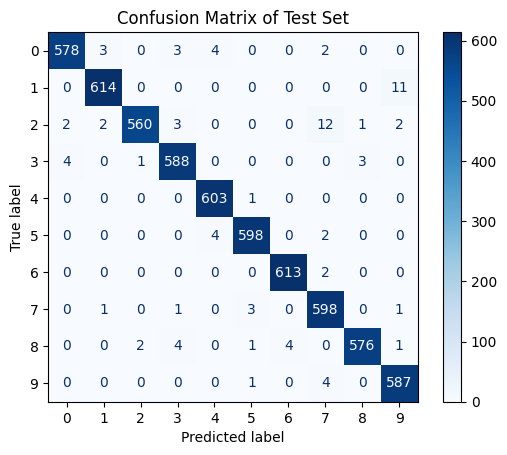

Test Set Accuracy: 0.986


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test).argmax(axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix of Test Set")
plt.show()

print(f"Test Set Accuracy: {round(history.history['val_accuracy'][-1], 3)}")